In [45]:
import csv
from datetime import datetime
import numpy as np
import trompy as tp

def get_FEDevents(filename, eventname):
    formats = ['%Y-%m-%d %H:%M:%S', '%m/%d/%Y %H:%M:%S']
    
    try:
        file = open(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return []
    
    csvreader = csv.reader(file)
    next(csvreader)  # Skip header
    rows = []
    for row in csvreader:
        rows.append(row)

    # Check if rows are empty
    if len(rows) == 0:
        print(f"No data found in file: {filename}")
        return []

    # Determine which format should be used
    try:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[0])
        date_format = formats[0]
    except ValueError:
        tmp_date_time_obj = datetime.strptime(rows[0][0], formats[1])
        date_format = formats[1]

    timestamps = []
    for row in rows: 
        if row[7] == eventname:  # Check event column
            date_time_obj = datetime.strptime(row[0], date_format)
            timestamps.append(date_time_obj)

    if len(timestamps) == 0:
        print(f"No {eventname} events found in file: {filename}")
        return []

    t0 = rows[0][0]
    day = t0.split()[0] 
    lightson = day + " 07:00:00"
    refpoint = datetime.strptime(lightson, date_format)
    
    pellettimes = []
    for t in timestamps:
        Deltat = t - refpoint
        Deltatinseconds = Deltat.total_seconds()
        Deltatinhours = Deltatinseconds / 3600
        pellettimes.append(Deltatinhours)

    return pellettimes


# Function to get meal, snack, and mega meal metrics, including mega_meal_frequency and mega_meal_size
def get_meal_and_snack_metrics(pellettimes, meal_threshold=1/60):
    if not pellettimes:
        return (0, 0, 0, 0, 0, 0, 0, 0, [[0]*24]*7, [[0]*24]*7, [[0]*24]*7, 0, 0, 0, 0)

    IPIs = np.diff(np.array(pellettimes))
    meals = []
    snacks = []
    mega_meals = []
    current_event = [pellettimes[0]]

    # Hourly tracking for each day
    hourly_meals_per_day = [[0]*24 for _ in range(7)]
    hourly_snacks_per_day = [[0]*24 for _ in range(7)]
    hourly_mega_meals_per_day = [[0]*24 for _ in range(7)]

    for i, ipi in enumerate(IPIs):
        if ipi <= meal_threshold:
            current_event.append(pellettimes[i + 1])
        else:
            if len(current_event) == 1:
                snacks.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:  # Make sure we are within the 7-day boundary
                    hourly_snacks_per_day[day_index][hour] += 1
            elif 2 <= len(current_event) <= 4:
                meals.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:
                    hourly_meals_per_day[day_index][hour] += 1
            elif len(current_event) >= 5:
                mega_meals.append(current_event)
                day_index = int(current_event[0] // 24)
                hour = int(current_event[0]) % 24
                if day_index < 7:
                    hourly_mega_meals_per_day[day_index][hour] += 1
            current_event = [pellettimes[i + 1]]

    # Handle the last sequence
    if current_event:
        day_index = int(current_event[0] // 24)
        hour = int(current_event[0]) % 24
        if len(current_event) == 1:
            snacks.append(current_event)
            if day_index < 7:
                hourly_snacks_per_day[day_index][hour] += 1
        elif 2 <= len(current_event) <= 4:
            meals.append(current_event)
            if day_index < 7:
                hourly_meals_per_day[day_index][hour] += 1
        elif len(current_event) >= 5:
            mega_meals.append(current_event)
            if day_index < 7:
                hourly_mega_meals_per_day[day_index][hour] += 1

    nmeals = len(meals)
    nsnacks = len(snacks)
    n_mega_meals = len(mega_meals)  # Add the number of mega meals

    total_pellets = len(pellettimes)
    mealsize = sum(len(meal) for meal in meals) / nmeals if nmeals else 0
    snack_size = sum(len(snack) for snack in snacks) / nsnacks if nsnacks else 0
    total_observation_period = max(pellettimes) - min(pellettimes)
    meal_frequency = nmeals / total_observation_period if total_observation_period > 0 else 0
    snack_frequency = nsnacks / total_observation_period if total_observation_period > 0 else 0
    mega_meal_frequency = n_mega_meals / total_observation_period if total_observation_period > 0 else 0
    average_mega_meal_size = sum(len(meal) for meal in mega_meals) / n_mega_meals if n_mega_meals else 0

    return (mealsize, snack_size, nmeals, meal_frequency, nsnacks, snack_frequency, 
            mega_meal_frequency, average_mega_meal_size, hourly_meals_per_day, 
            hourly_snacks_per_day, hourly_mega_meals_per_day, meals, snacks, mega_meals, n_mega_meals)


# Function to get events (meals, snacks, mega meals) per day based on timestamps
def get_events_per_day(events, days=7):
    events_per_day = [0] * days  # Initialize with zeros for the duration of the phase
    for event_list in events:
        if len(event_list) > 0:
            event_day = int(event_list[0] // 24)
            if event_day < days:
                events_per_day[event_day] += 1
    return events_per_day

# Function to calculate pellets per day
def get_pellets_per_day(timestamps, days=7):
    pellets_per_day = [0] * days
    for day in range(days):
        pellets = [t for t in timestamps if (t > day * 24) and (t < (day + 1) * 24)]
        n_pellets = len(pellets)
        pellets_per_day[day] = n_pellets

    return pellets_per_day


# Function to calculate inter-pellet intervals (IPI)
def get_interpellet_intervals(pellettimes):
    IPIs = np.diff(pellettimes)
    return IPIs

# Function to calculate intermeal intervals (IMI)
def get_intermeal_interval(pellettimes, meal_threshold=1/60):
    IPIs = np.diff(pellettimes)
    IMIs = [x for x in IPIs if x > meal_threshold]
    average_IMI = np.mean(IMIs) if IMIs else 0  # Handle case with no IMIs
    return average_IMI

# Load the metafile and process the data
metafile = "..\\FEDProtein_METAFILE.xls"
rows, header = tp.metafilereader(metafile, sheetname="METAFILE")

mice = {}
for row in rows:
    mouse_id = row[1]
    if mouse_id not in mice.keys():
        mice[mouse_id] = {}
        mice[mouse_id]["sex"] = row[4]
        mice[mouse_id]["order"] = row[5]

for key in mice.keys():
    for row in rows:
        if row[1] == key and row[3] == "FF":
            filename = "..\\data\\{}".format(row[0])
            if row[2] == "GRAIN":
                mice[key]["grain_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "PR":
                mice[key]["pr_timestamps"] = get_FEDevents(filename, "Pellet")
            elif row[2] == "NR":
                mice[key]["nr_timestamps"] = get_FEDevents(filename, "Pellet")
            else:
                print(row[2], "is not a valid type of pellet for", key)

# Add meal, snack, mega meal metrics, and IMI, IPI calculations to the dictionary
for key in mice.keys():
    grain_timestamps = mice[key].get("grain_timestamps", [])
    pr_timestamps = mice[key].get("pr_timestamps", [])
    nr_timestamps = mice[key].get("nr_timestamps", [])

    # Get metrics for GRAIN, PR, and NR phases
    grain_metrics = get_meal_and_snack_metrics(grain_timestamps)
    pr_metrics = get_meal_and_snack_metrics(pr_timestamps)
    nr_metrics = get_meal_and_snack_metrics(nr_timestamps)

    # GRAIN phase
    (
        mice[key]["grain_meal_size"],
        mice[key]["grain_snack_size"],
        mice[key]["grain_number_of_meals"],
        mice[key]["grain_meal_frequency"],
        mice[key]["grain_number_of_snacks"],
        mice[key]["grain_snack_frequency"],
        mice[key]["grain_mega_meal_frequency"],
        mice[key]["grain_mega_meal_size"],
        mice[key]["grain_hourly_meals"],
        mice[key]["grain_hourly_snacks"],
        mice[key]["grain_hourly_mega_meals"],
        grain_meals,
        grain_snacks,
        grain_mega_meals,
        mice[key]["grain_number_of_mega_meals"]  # Store the number of mega meals
    ) = grain_metrics

    # PR phase
    (
        mice[key]["pr_meal_size"],
        mice[key]["pr_snack_size"],
        mice[key]["pr_number_of_meals"],
        mice[key]["pr_meal_frequency"],
        mice[key]["pr_number_of_snacks"],
        mice[key]["pr_snack_frequency"],
        mice[key]["pr_mega_meal_frequency"],
        mice[key]["pr_mega_meal_size"],
        mice[key]["pr_hourly_meals"],
        mice[key]["pr_hourly_snacks"],
        mice[key]["pr_hourly_mega_meals"],
        pr_meals,
        pr_snacks,
        pr_mega_meals,
        mice[key]["pr_number_of_mega_meals"]  # Store the number of mega meals
    ) = pr_metrics

    # NR phase
    (
        mice[key]["nr_meal_size"],
        mice[key]["nr_snack_size"],
        mice[key]["nr_number_of_meals"],
        mice[key]["nr_meal_frequency"],
        mice[key]["nr_number_of_snacks"],
        mice[key]["nr_snack_frequency"],
        mice[key]["nr_mega_meal_frequency"],
        mice[key]["nr_mega_meal_size"],
        mice[key]["nr_hourly_meals"],
        mice[key]["nr_hourly_snacks"],
        mice[key]["nr_hourly_mega_meals"],
        nr_meals,
        nr_snacks,
        nr_mega_meals,
        mice[key]["nr_number_of_mega_meals"]  # Store the number of mega meals
    ) = nr_metrics

    # Events per day and pellets per day (as previously done)
    mice[key]["grain_meals_per_day"] = get_events_per_day(grain_meals, days=3)
    mice[key]["pr_meals_per_day"] = get_events_per_day(pr_meals, days=7)
    mice[key]["nr_meals_per_day"] = get_events_per_day(nr_meals, days=7)

    mice[key]["grain_snacks_per_day"] = get_events_per_day(grain_snacks, days=3)
    mice[key]["pr_snacks_per_day"] = get_events_per_day(pr_snacks, days=7)
    mice[key]["nr_snacks_per_day"] = get_events_per_day(nr_snacks, days=7)

    mice[key]["grain_mega_meals_per_day"] = get_events_per_day(grain_mega_meals, days=3)
    mice[key]["pr_mega_meals_per_day"] = get_events_per_day(pr_mega_meals, days=7)
    mice[key]["nr_mega_meals_per_day"] = get_events_per_day(nr_mega_meals, days=7)

    mice[key]["grain_pellets_per_day"] = get_pellets_per_day(mice[key]["grain_timestamps"], days=3)
    mice[key]["pr_pellets_per_day"] = get_pellets_per_day(mice[key]["pr_timestamps"], days=7)
    mice[key]["nr_pellets_per_day"] = get_pellets_per_day(mice[key]["nr_timestamps"], days=7)


# Now combine events and pellets per day for the entire 17-day time course (as before)
for key in mice.keys():
    # Combine pellets per day
    mice[key]["all_pellets_per_day"] = (
        mice[key].get("grain_pellets_per_day", [0] * 3) +
        mice[key].get("pr_pellets_per_day", [0] * 7) +
        mice[key].get("nr_pellets_per_day", [0] * 7)
    )

    # Combine meals per day
    mice[key]["all_meals_per_day"] = (
        mice[key].get("grain_meals_per_day", [0] * 3) +
        mice[key].get("pr_meals_per_day", [0] * 7) +
        mice[key].get("nr_meals_per_day", [0] * 7)
    )

    # Combine snacks per day
    mice[key]["all_snacks_per_day"] = (
        mice[key].get("grain_snacks_per_day", [0] * 3) +
        mice[key].get("pr_snacks_per_day", [0] * 7) +
        mice[key].get("nr_snacks_per_day", [0] * 7)
    )

    # Combine mega meals per day
    mice[key]["all_mega_meals_per_day"] = (
        mice[key].get("grain_mega_meals_per_day", [0] * 3) +
        mice[key].get("pr_mega_meals_per_day", [0] * 7) +
        mice[key].get("nr_mega_meals_per_day", [0] * 7)
    )

# Output the results to check the data structure
for key, value in mice.items():
    print(f"Mouse {key}:")
    print("  Pellets per day:", mice[key]["all_pellets_per_day"])
    print("  Meals per day:", mice[key]["all_meals_per_day"])
    print("  Snacks per day:", mice[key]["all_snacks_per_day"])
    print("  Mega Meals per hour:", mice[key]["nr_hourly_mega_meals"])
    print("  Mega Meals Frequency:", mice[key]["nr_mega_meal_frequency"])
    print("  Mega Meals Size:", mice[key]["nr_mega_meal_size"])


Mouse FEDXA01:
  Pellets per day: [340, 271, 224, 161, 155, 176, 184, 215, 231, 240, 246, 234, 222, 211, 241, 223, 219]
  Meals per day: [43, 25, 23, 35, 28, 31, 24, 24, 31, 14, 9, 18, 18, 15, 13, 9, 6]
  Snacks per day: [30, 18, 25, 32, 44, 52, 62, 28, 25, 13, 13, 14, 14, 19, 18, 12, 13]
  Mega Meals per hour: [[0, 0, 0, 2, 1, 2, 1, 0, 1, 0, 2, 1, 1, 1, 1, 2, 3, 3, 1, 2, 0, 1, 1, 1], [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 2, 3, 3, 2, 1, 2, 0, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 0, 1, 0, 0, 3], [0, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 0, 1, 1, 1, 0], [1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 1, 4, 2, 3, 2, 0, 1, 0, 1, 1], [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 0, 2], [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 2]]
  Mega Meals Frequency: 1.0133227626203154
  Mega Meals Size: 7.27810650887574
Mouse FEDXA02:
  Pellets per day: [304, 214, 194, 154, 153, 204, 211, 203, 226, 214, 225,

In [46]:
mice["FEDXB01"].keys()

dict_keys(['sex', 'order', 'grain_timestamps', 'pr_timestamps', 'nr_timestamps', 'grain_meal_size', 'grain_snack_size', 'grain_number_of_meals', 'grain_meal_frequency', 'grain_number_of_snacks', 'grain_snack_frequency', 'grain_mega_meal_frequency', 'grain_mega_meal_size', 'grain_hourly_meals', 'grain_hourly_snacks', 'grain_hourly_mega_meals', 'grain_number_of_mega_meals', 'pr_meal_size', 'pr_snack_size', 'pr_number_of_meals', 'pr_meal_frequency', 'pr_number_of_snacks', 'pr_snack_frequency', 'pr_mega_meal_frequency', 'pr_mega_meal_size', 'pr_hourly_meals', 'pr_hourly_snacks', 'pr_hourly_mega_meals', 'pr_number_of_mega_meals', 'nr_meal_size', 'nr_snack_size', 'nr_number_of_meals', 'nr_meal_frequency', 'nr_number_of_snacks', 'nr_snack_frequency', 'nr_mega_meal_frequency', 'nr_mega_meal_size', 'nr_hourly_meals', 'nr_hourly_snacks', 'nr_hourly_mega_meals', 'nr_number_of_mega_meals', 'grain_meals_per_day', 'pr_meals_per_day', 'nr_meals_per_day', 'grain_snacks_per_day', 'pr_snacks_per_day', '

In [47]:
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"} 

In [17]:
nrpr_m_mega_meals = get_data_fields(mice, ["all_meals_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_meals_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_female_selector)


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


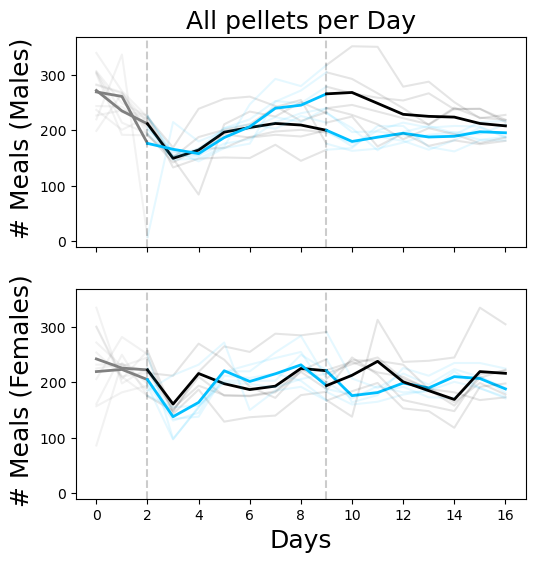

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot individual timelines
def timeline_fig(data, ax=[], ylabel="", **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided
    
    for trace in data:
        ax.plot(trace, color="grey", alpha=0.3)  # Plot individual traces with transparency
    ax.plot(np.mean(data, axis=0), linewidth=2)  # Plot the mean line

    ax.set_ylabel(ylabel)
    ax.axvline(2, linestyle="--", color="k")  # Add vertical reference lines
    ax.axvline(9, linestyle="--", color="k")

    return ax

# Function to plot multicolored timeline with split phases (PR/NR)
def timeline_multicolor_fig(data, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided

    for group in data:
        for trace in group:
            trace = trace[:max_days]  # Ensure the trace is within the max_days range
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)  # Plot the grey phase
            ax.plot(range(2, 10), trace[2:10], color=colors[0], alpha=0.1)  # First phase in color
            ax.plot(range(9, len(trace)), trace[9:], color=colors[1], alpha=0.1)  # Second phase in color

        # Plot the mean values
        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)  # Grey phase mean
        ax.plot(range(2, 10), mean[2:10], color=colors[0], linewidth=2)  # First phase mean
        ax.plot(range(9, len(mean)), mean[9:], color=colors[1], linewidth=2)  # Second phase mean

        colors.reverse()  # Alternate color for next group

    ax.set_ylabel(ylabel, fontsize=18)
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)  # Add phase split lines
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

    return ax

# Selectors for grouping mice data
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for mega meals per day
nrpr_m_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_pellets_per_day"], prnr_female_selector)

# Plot the mega meals per day trend using a similar layout to your pellet intake plot
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6), gridspec_kw={"left": 0.15})

# Plot for males
timeline_multicolor_fig([nrpr_m_mega_meals, prnr_m_mega_meals], colors=["black", "deepskyblue"], ylabel=" # Meals (Males)", ax=ax[0])

# Plot for females
timeline_multicolor_fig([nrpr_f_mega_meals, prnr_f_mega_meals], colors=["black", "deepskyblue"], ylabel=" # Meals (Females)", ax=ax[1])

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=18)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# Add title for the overall figure
ax[0].set_title("All pellets per Day", fontsize=18)

# Show the plot
plt.show()

# Save the figure if needed
figfolder = r"..//plots/NEW_MEAL_PLOTS//"
# f.savefig(figfolder + "timeline_mega_meals_per_day.pdf")

6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


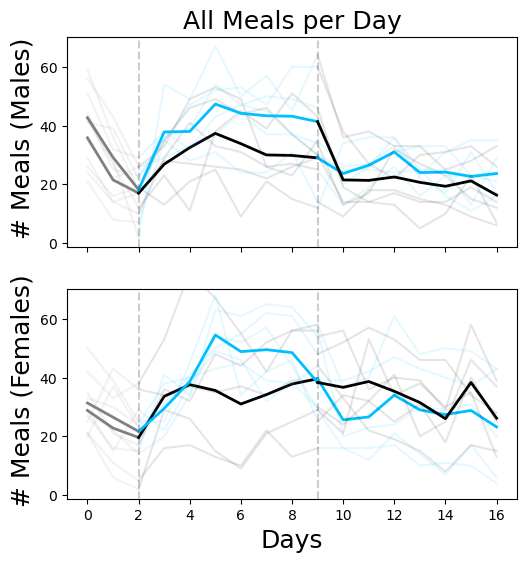

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot individual timelines
def timeline_fig(data, ax=[], ylabel="", **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided
    
    for trace in data:
        ax.plot(trace, color="grey", alpha=0.3)  # Plot individual traces with transparency
    ax.plot(np.mean(data, axis=0), linewidth=2)  # Plot the mean line

    ax.set_ylabel(ylabel)
    ax.axvline(2, linestyle="--", color="k")  # Add vertical reference lines
    ax.axvline(9, linestyle="--", color="k")

    return ax

# Function to plot multicolored timeline with split phases (PR/NR)
def timeline_multicolor_fig(data, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided

    for group in data:
        for trace in group:
            trace = trace[:max_days]  # Ensure the trace is within the max_days range
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)  # Plot the grey phase
            ax.plot(range(2, 10), trace[2:10], color=colors[0], alpha=0.1)  # First phase in color
            ax.plot(range(9, len(trace)), trace[9:], color=colors[1], alpha=0.1)  # Second phase in color

        # Plot the mean values
        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)  # Grey phase mean
        ax.plot(range(2, 10), mean[2:10], color=colors[0], linewidth=2)  # First phase mean
        ax.plot(range(9, len(mean)), mean[9:], color=colors[1], linewidth=2)  # Second phase mean

        colors.reverse()  # Alternate color for next group

    ax.set_ylabel(ylabel, fontsize=18)
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)  # Add phase split lines
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

    return ax

# Selectors for grouping mice data
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for mega meals per day
nrpr_m_mega_meals = get_data_fields(mice, ["all_meals_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_meals_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_female_selector)

# Plot the mega meals per day trend using a similar layout to your pellet intake plot
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6), gridspec_kw={"left": 0.15})

# Plot for males
timeline_multicolor_fig([nrpr_m_mega_meals, prnr_m_mega_meals], colors=["black", "deepskyblue"], ylabel=" # Meals (Males)", ax=ax[0])

# Plot for females
timeline_multicolor_fig([nrpr_f_mega_meals, prnr_f_mega_meals], colors=["black", "deepskyblue"], ylabel=" # Meals (Females)", ax=ax[1])

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=18)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# Add title for the overall figure
ax[0].set_title("All Meals per Day", fontsize=18)

# Show the plot
plt.show()

# Save the figure if needed
figfolder = r"..//plots/NEW_MEAL_PLOTS//"
# f.savefig(figfolder + "timeline_mega_meals_per_day.pdf")

6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


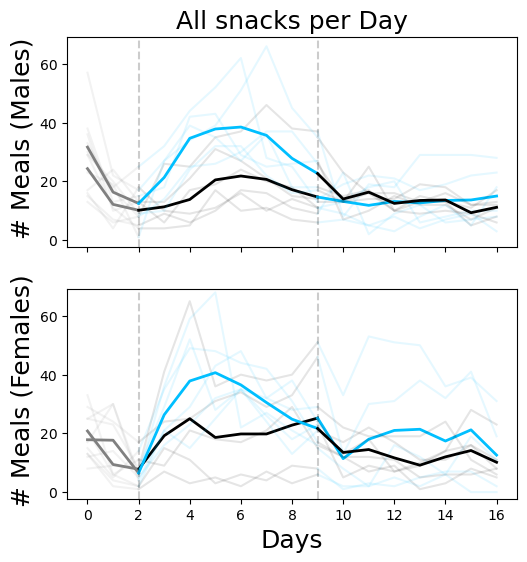

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot individual timelines
def timeline_fig(data, ax=[], ylabel="", **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided
    
    for trace in data:
        ax.plot(trace, color="grey", alpha=0.3)  # Plot individual traces with transparency
    ax.plot(np.mean(data, axis=0), linewidth=2)  # Plot the mean line

    ax.set_ylabel(ylabel)
    ax.axvline(2, linestyle="--", color="k")  # Add vertical reference lines
    ax.axvline(9, linestyle="--", color="k")

    return ax

# Function to plot multicolored timeline with split phases (PR/NR)
def timeline_multicolor_fig(data, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided

    for group in data:
        for trace in group:
            trace = trace[:max_days]  # Ensure the trace is within the max_days range
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)  # Plot the grey phase
            ax.plot(range(2, 10), trace[2:10], color=colors[0], alpha=0.1)  # First phase in color
            ax.plot(range(9, len(trace)), trace[9:], color=colors[1], alpha=0.1)  # Second phase in color

        # Plot the mean values
        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)  # Grey phase mean
        ax.plot(range(2, 10), mean[2:10], color=colors[0], linewidth=2)  # First phase mean
        ax.plot(range(9, len(mean)), mean[9:], color=colors[1], linewidth=2)  # Second phase mean

        colors.reverse()  # Alternate color for next group

    ax.set_ylabel(ylabel, fontsize=18)
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)  # Add phase split lines
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

    return ax

# Selectors for grouping mice data
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for mega meals per day
nrpr_m_mega_meals = get_data_fields(mice, ["all_snacks_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_snacks_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_snacks_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_snacks_per_day"], prnr_female_selector)

# Plot the mega meals per day trend using a similar layout to your pellet intake plot
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6), gridspec_kw={"left": 0.15})

# Plot for males
timeline_multicolor_fig([nrpr_m_mega_meals, prnr_m_mega_meals], colors=["black", "deepskyblue"], ylabel=" # Meals (Males)", ax=ax[0])

# Plot for females
timeline_multicolor_fig([nrpr_f_mega_meals, prnr_f_mega_meals], colors=["black", "deepskyblue"], ylabel=" # Meals (Females)", ax=ax[1])

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=18)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# Add title for the overall figure
ax[0].set_title("All snacks per Day", fontsize=18)

# Show the plot
plt.show()

# Save the figure if needed
figfolder = r"..//plots/NEW_MEAL_PLOTS//"
# f.savefig(figfolder + "timeline_mega_meals_per_day.pdf")

6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


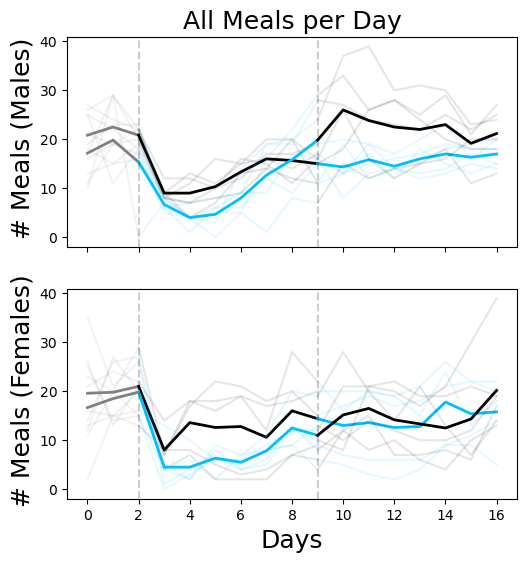

6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


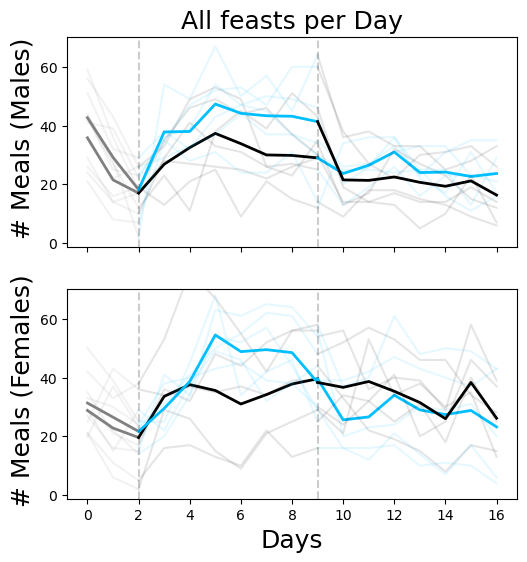

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot individual timelines
def timeline_fig(data, ax=[], ylabel="", **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided
    
    for trace in data:
        ax.plot(trace, color="grey", alpha=0.3)  # Plot individual traces with transparency
    ax.plot(np.mean(data, axis=0), linewidth=2)  # Plot the mean line

    ax.set_ylabel(ylabel)
    ax.axvline(2, linestyle="--", color="k")  # Add vertical reference lines
    ax.axvline(9, linestyle="--", color="k")

    return ax

# Function to plot multicolored timeline with split phases (PR/NR)
def timeline_multicolor_fig(data, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided

    for group in data:
        for trace in group:
            trace = trace[:max_days]  # Ensure the trace is within the max_days range
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)  # Plot the grey phase
            ax.plot(range(2, 10), trace[2:10], color=colors[0], alpha=0.1)  # First phase in color
            ax.plot(range(9, len(trace)), trace[9:], color=colors[1], alpha=0.1)  # Second phase in color

        # Plot the mean values
        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)  # Grey phase mean
        ax.plot(range(2, 10), mean[2:10], color=colors[0], linewidth=2)  # First phase mean
        ax.plot(range(9, len(mean)), mean[9:], color=colors[1], linewidth=2)  # Second phase mean

        colors.reverse()  # Alternate color for next group

    ax.set_ylabel(ylabel, fontsize=18)
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)  # Add phase split lines
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

    return ax

# Selectors for grouping mice data
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for mega meals per day
nrpr_m_mega_meals = get_data_fields(mice, ["all_mega_meals_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_mega_meals_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_mega_meals_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_mega_meals_per_day"], prnr_female_selector)

# Plot the mega meals per day trend using a similar layout to your pellet intake plot
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6), gridspec_kw={"left": 0.15})

# Plot for males
timeline_multicolor_fig([nrpr_m_mega_meals, prnr_m_mega_meals], colors=["black", "deepskyblue"], ylabel=" # Meals (Males)", ax=ax[0])

# Plot for females
timeline_multicolor_fig([nrpr_f_mega_meals, prnr_f_mega_meals], colors=["black", "deepskyblue"], ylabel=" # Meals (Females)", ax=ax[1])

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=18)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# Add title for the overall figure
ax[0].set_title("All Meals per Day", fontsize=18)

# Show the plot
plt.show()

# Save the figure if needed
figfolder = r"..//plots/NEW_MEAL_PLOTS//"
# f.savefig(figfolder + "timeline_mega_meals_per_day.pdf")import matplotlib.pyplot as plt
import numpy as np

# Function to plot individual timelines
def timeline_fig(data, ax=[], ylabel="", **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided
    
    for trace in data:
        ax.plot(trace, color="grey", alpha=0.3)  # Plot individual traces with transparency
    ax.plot(np.mean(data, axis=0), linewidth=2)  # Plot the mean line

    ax.set_ylabel(ylabel)
    ax.axvline(2, linestyle="--", color="k")  # Add vertical reference lines
    ax.axvline(9, linestyle="--", color="k")

    return ax

# Function to plot multicolored timeline with split phases (PR/NR)
def timeline_multicolor_fig(data, ax=[], ylabel="", colors=[], day_split=[2, 9], max_days=17, **kwargs):
    if ax == []:
        f, ax = plt.subplots()  # Create a new figure and axis if none are provided

    for group in data:
        for trace in group:
            trace = trace[:max_days]  # Ensure the trace is within the max_days range
            ax.plot(range(0, 3), trace[:3], color="grey", alpha=0.1)  # Plot the grey phase
            ax.plot(range(2, 10), trace[2:10], color=colors[0], alpha=0.1)  # First phase in color
            ax.plot(range(9, len(trace)), trace[9:], color=colors[1], alpha=0.1)  # Second phase in color

        # Plot the mean values
        mean = np.mean(group, axis=0)[:max_days]
        ax.plot(range(0, 3), mean[:3], color="grey", linewidth=2)  # Grey phase mean
        ax.plot(range(2, 10), mean[2:10], color=colors[0], linewidth=2)  # First phase mean
        ax.plot(range(9, len(mean)), mean[9:], color=colors[1], linewidth=2)  # Second phase mean

        colors.reverse()  # Alternate color for next group

    ax.set_ylabel(ylabel, fontsize=18)
    ax.axvline(2, linestyle="--", color="k", alpha=0.2)  # Add phase split lines
    ax.axvline(9, linestyle="--", color="k", alpha=0.2)

    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

    return ax

# Selectors for grouping mice data
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}
nrpr_female_selector = {"order": 1, "sex": "F"}
prnr_female_selector = {"order": 2, "sex": "F"}

# Get data for mega meals per day
nrpr_m_mega_meals = get_data_fields(mice, ["all_meals_per_day"], nrpr_male_selector)
prnr_m_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_male_selector)
nrpr_f_mega_meals = get_data_fields(mice, ["all_meals_per_day"], nrpr_female_selector)
prnr_f_mega_meals = get_data_fields(mice, ["all_meals_per_day"], prnr_female_selector)

# Plot the mega meals per day trend using a similar layout to your pellet intake plot
f, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6), gridspec_kw={"left": 0.15})

# Plot for males
timeline_multicolor_fig([nrpr_m_mega_meals, prnr_m_mega_meals], colors=["black", "deepskyblue"], ylabel=" # Meals (Males)", ax=ax[0])

# Plot for females
timeline_multicolor_fig([nrpr_f_mega_meals, prnr_f_mega_meals], colors=["black", "deepskyblue"], ylabel=" # Meals (Females)", ax=ax[1])

# Set common X-axis label
ax[1].set_xlabel("Days", fontsize=18)

# Set a common Y-axis limit for better comparison
ax[1].set_ylim(ax[0].get_ylim())

# Add title for the overall figure
ax[0].set_title("All feasts per Day", fontsize=18)

# Show the plot
plt.show()

# Save the figure if needed
figfolder = r"..//plots/NEW_MEAL_PLOTS//"
# f.savefig(figfolder + "timeline_mega_meals_per_day.pdf")

6 items in output dictionary
6 items in output dictionary


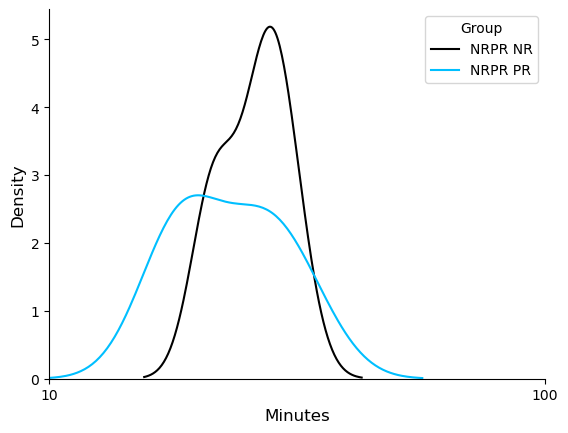

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import trompy as tp

def intermeal_interval_plot(data, ax=[], colors=[], fill=False, labels=[], linestyle="-", xlim=(1, 2), **kwargs):
    """
    FED3 Viz: Plot a KDE of intermeal intervals for multiple groups.
    Parameters
    ----------
    data : list of lists
        Intermeal intervals for each group (e.g., for NRPR and PRNR)
    ax : matplotlib.axes.Axes
        Axes to plot on, a new Figure and Axes are
        created if not passed
    colors : list of str
        List of colors for each group
    fill : bool
        Whether to fill the area under the KDE curve
    labels : list of str
        List of labels for each group
    linestyle : str
        Line style for the KDE plot
    xlim : tuple of floats
        The limits for the x-axis (in log10 scale)
    **kwargs :
        Additional keyword arguments to pass to seaborn.kdeplot
    Returns
    -------
    ax : matplotlib.axes.Axes
        The axes object with the plot
    """

    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)

    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    for idx, group in enumerate(data):
        if not isinstance(group, list) or not group:
            print(f"Skipping group {idx} due to improper format or empty data.")
            continue

        try:
            # Directly use the data without flattening
            y = [np.log10(val * 60) for val in group if val > 0]
        except Exception as e:
            print(f"Error processing data for group {idx}: {e}")
            y = []

        if y:
            sns.kdeplot(y, ax=ax,
                        color=colors[idx],
                        fill=fill,
                        label=labels[idx],
                        linestyle=linestyle)

    ax.set_ylabel('Density', fontsize=12)
    ax.set_xlabel('Minutes', fontsize=12)

    # Set x-axis ticks for the log10 range from 10 to 100 minutes
    ax.set_xticks([1, 2])
    ax.set_xticklabels([10, 100])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Set x-axis limits to focus on the relevant range (10 to 100 minutes)
    ax.set_xlim(xlim)

    if labels:
        ax.legend(title="Group")

    return ax

# Example usage for plotting intermeal intervals
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

IMIs_m_nrpr_pr = get_data_fields(mice, ["pr_imi"], nrpr_male_selector)
IMIs_m_nrpr_nr = get_data_fields(mice, ["nr_imi"], nrpr_male_selector)

# IMIs_m_prnr_pr = get_data_fields(mice, ["intermeal_interval_pr"], prnr_male_selector)
# IMIs_m_prnr_nr = get_data_fields(mice, ["intermeal_interval_nr"], prnr_male_selector)

f, ax = plt.subplots()

intermeal_interval_plot([IMIs_m_nrpr_nr, IMIs_m_nrpr_pr],
                        colors=["black", "deepskyblue"],
                        linestyle="-",
                        ax=ax,
                        labels=["NRPR NR", "NRPR PR"],
                        xlim=(1, 2))  # Set x-axis limits to focus on 10 to 100 minutes

# intermeal_interval_plot([IMIs_m_prnr_nr, IMIs_m_prnr_pr],
#                         colors=["black", "deepskyblue"],
#                         linestyle="--",
#                         ax=ax,
#                         labels=["PRNR NR", "PRNR PR"],
#                         xlim=(1, 2))  # Set x-axis limits to focus on 10 to 100 minutes

ax.legend(title="Group")


In [23]:
def interpellet_interval_plot(data, ax=[], colors=[], fill=False, labels=[], linestyle="-", **kwargs):
    """
    FED3 Viz: Plot a histogram of interpellet intervals for multiple devices.
    Parameters
    ----------
    FEDs : list of FED3_File objects
        FED3 files (loaded by load.FED3_File)
    kde : bool
        Whether or not to include kernel density estimation, which plots
        probability density (rather than count) and includes a fit line (see
        seaborn.distplot)
    **kwargs :
        ax : matplotlib.axes.Axes
            Axes to plot on, a new Figure and Axes are
            created if not passed
        date_filter : array
            A two-element array of datetimes (start, end) used to filter
            the data
        **kwargs also allows FED3 Viz to pass all settings to all functions.
    Returns
    -------
    fig : matplotlib.figure.Figure
    """

    if ax == []:
        f, ax = plt.subplots()

    if len(colors) != len(data):
        colors = ["grey"] * len(data)
    print(colors)

    if len(labels) != len(data):
        labels = [str(n) for n in range(len(data))]

    for idx, group in enumerate(data):

        y = tp.flatten_list(group)
        y = [np.log10(val*60) for val in y if val > 0]
            
        sns.kdeplot(y, ax=ax,
                    color=colors[idx],
                    fill=fill,
                    label=labels[idx],
                    linestyle=linestyle)

    ax.set_ylabel('Density Estimation',fontsize = 18)
    ax.set_xlabel('Minutes between pellets',fontsize = 18)

    ax.set_xticks(range(-2,4))
    ax.set_xticklabels([10**num for num in range(-2,4)])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
6 items in output dictionary
['grey', 'deepskyblue']
['grey', 'deepskyblue']


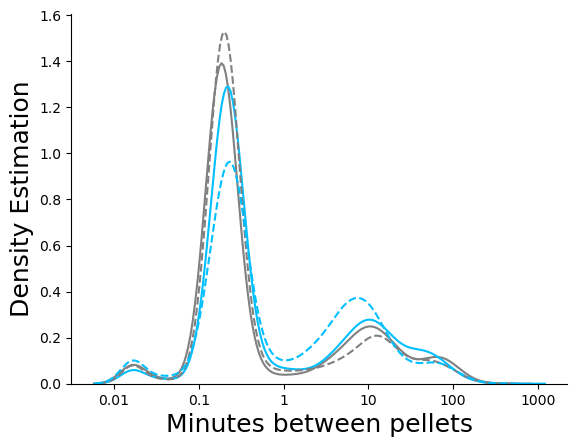

In [26]:
nrpr_male_selector = {"order": 1, "sex": "M"}
prnr_male_selector = {"order": 2, "sex": "M"}

IPIs_m_nrpr_pr = get_data_fields(mice, ["pr_ipi"], nrpr_male_selector)
IPIs_m_nrpr_nr = get_data_fields(mice, ["nr_ipi"], nrpr_male_selector)

IPIs_m_prnr_pr = get_data_fields(mice, ["pr_ipi"], prnr_male_selector)
IPIs_m_prnr_nr = get_data_fields(mice, ["nr_ipi"], prnr_male_selector)

f, ax = plt.subplots()

interpellet_interval_plot([IPIs_m_nrpr_nr, IPIs_m_nrpr_pr],
                           colors=["grey", "deepskyblue"],
                           linestyle="-",
                           ax=ax)

interpellet_interval_plot([IPIs_m_prnr_nr, IPIs_m_prnr_pr],
                           colors=["grey", "deepskyblue"],
                           linestyle="--",
                           ax=ax)

6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


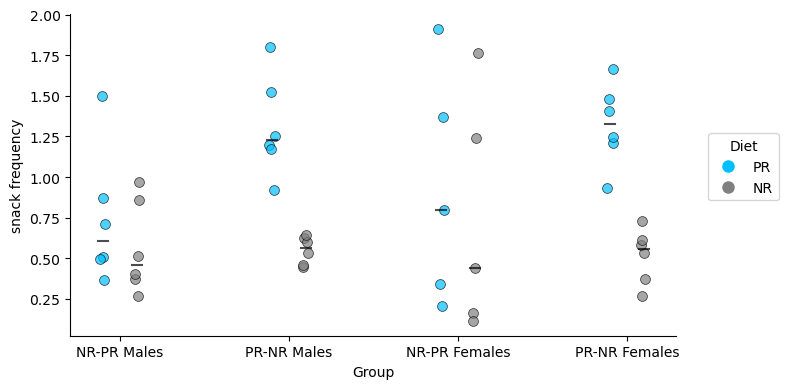

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_snack_frequency","nr_snack_frequency"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_snack_frequency", "nr_snack_frequency"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_snack_frequency","nr_snack_frequency"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_snack_frequency","nr_snack_frequency"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("snack frequency")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


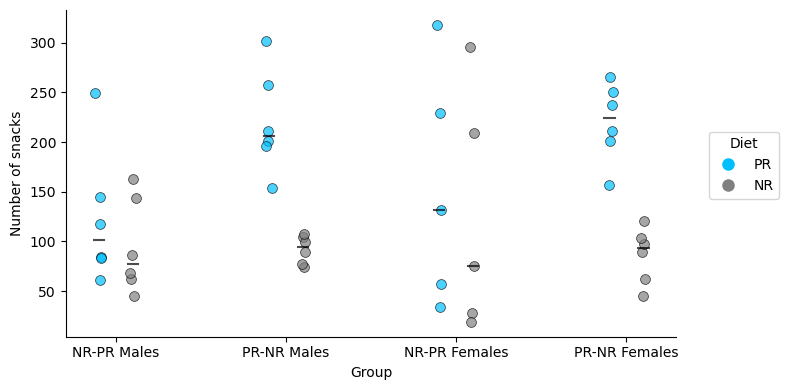

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_number_of_snacks","nr_number_of_snacks"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_number_of_snacks", "nr_number_of_snacks"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_number_of_snacks","nr_number_of_snacks"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_number_of_snacks","nr_number_of_snacks"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("Number of snacks")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


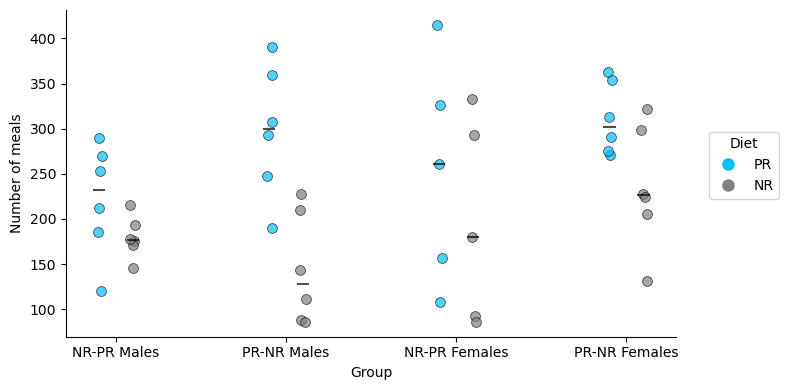

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_number_of_meals","nr_number_of_meals"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_number_of_meals", "nr_number_of_meals"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_number_of_meals","nr_number_of_meals"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_number_of_meals","nr_number_of_meals"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("Number of meals")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


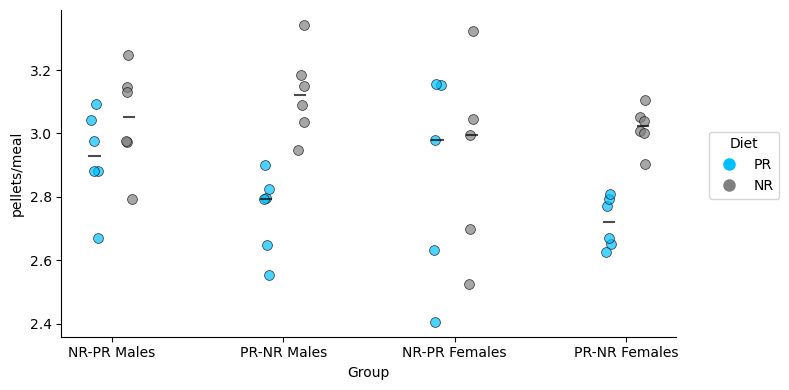

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_meal_size","nr_meal_size"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_meal_size", "nr_meal_size"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_meal_size","nr_meal_size"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_meal_size","nr_meal_size"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("pellets/meal")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


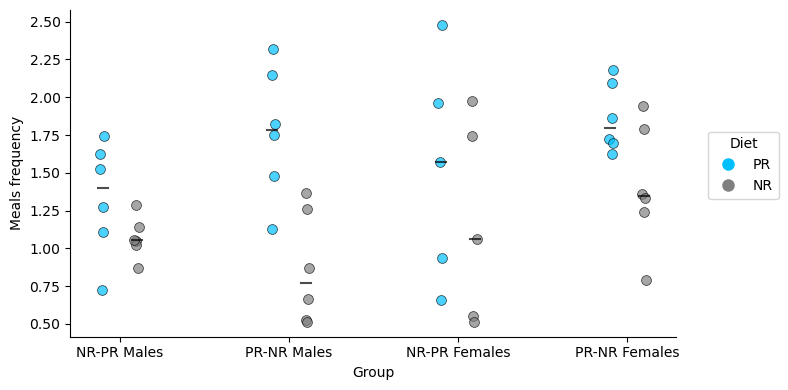

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_meal_frequency","nr_meal_frequency"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_meal_frequency", "nr_meal_frequency"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_meal_frequency","nr_meal_frequency"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_meal_frequency","nr_meal_frequency"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("Meals frequency")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


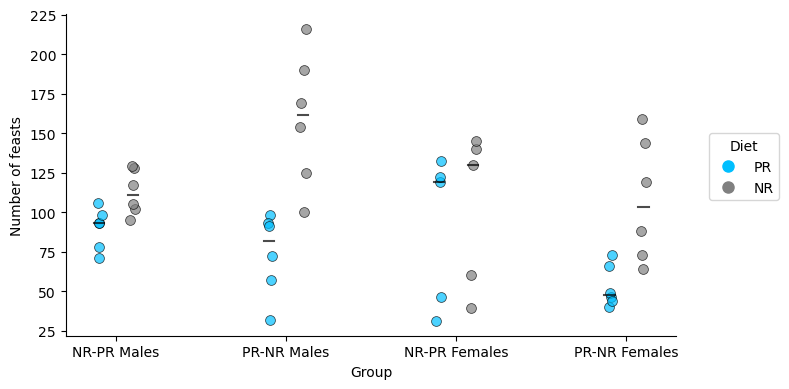

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_number_of_mega_meals","nr_number_of_mega_meals"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_number_of_mega_meals", "nr_number_of_mega_meals"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_number_of_mega_meals","nr_number_of_mega_meals"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_number_of_mega_meals","nr_number_of_mega_meals"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("Number of feasts")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


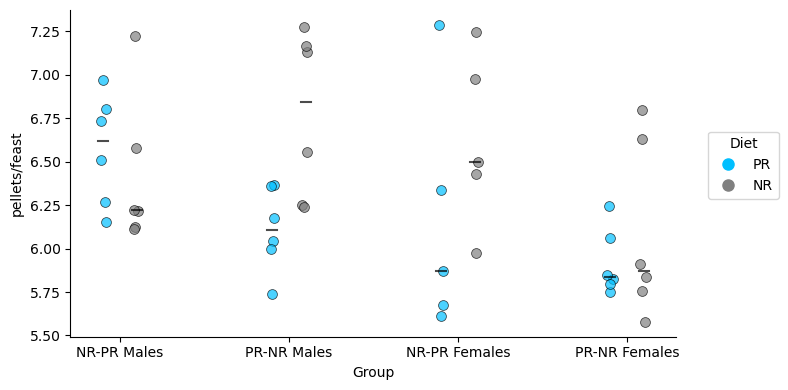

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_mega_meal_size","nr_mega_meal_size"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_mega_meal_size", "nr_mega_meal_size"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_mega_meal_size","nr_mega_meal_size"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_mega_meal_size","nr_mega_meal_size"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("pellets/feast")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


6 items in output dictionary
6 items in output dictionary
5 items in output dictionary
6 items in output dictionary


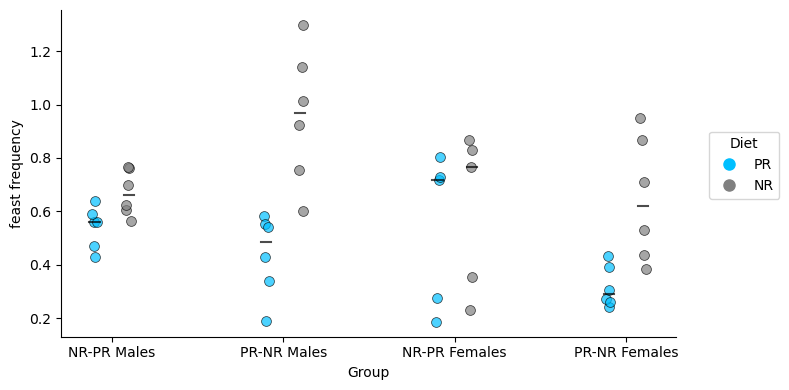

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data extraction using your actual function
nrpr_avg = get_data_fields(mice, ["pr_mega_meal_frequency","nr_mega_meal_frequency"], nrpr_male_selector)
prnr_avg = get_data_fields(mice, ["pr_mega_meal_frequency", "nr_mega_meal_frequency"], prnr_male_selector)
nrprf_avg = get_data_fields(mice, ["pr_mega_meal_frequency","nr_mega_meal_frequency"], nrpr_female_selector)
prnrf_avg = get_data_fields(mice, ["pr_mega_meal_frequency","nr_mega_meal_frequency"], prnr_female_selector)

# Combine all data for easier plotting
data = [nrpr_avg[0], nrpr_avg[1], prnr_avg[0], prnr_avg[1],
        nrprf_avg[0], nrprf_avg[1], prnrf_avg[0], prnrf_avg[1]]

group_labels = ["NR-PR Males (PR)", "NR-PR Males (NR)", "PR-NR Males (PR)", "PR-NR Males (NR)",
                "NR-PR Females (PR)", "NR-PR Females (NR)", "PR-NR Females (PR)", "PR-NR Females (NR)"]

colors = {"PR": "deepskyblue", "NR": "grey"}
offset = {"PR": -0.1, "NR": 0.1}  # Reduced offset for compactness
group_mapping = {
    "NR-PR Males (PR)": ("NR-PR Males", "PR"),
    "NR-PR Males (NR)": ("NR-PR Males", "NR"),
    "PR-NR Males (PR)": ("PR-NR Males", "PR"),
    "PR-NR Males (NR)": ("PR-NR Males", "NR"),
    "NR-PR Females (PR)": ("NR-PR Females", "PR"),
    "NR-PR Females (NR)": ("NR-PR Females", "NR"),
    "PR-NR Females (PR)": ("PR-NR Females", "PR"),
    "PR-NR Females (NR)": ("PR-NR Females", "NR")
}

group_positions = {
    "NR-PR Males": 0,
    "PR-NR Males": 1,
    "NR-PR Females": 2,
    "PR-NR Females": 3
}

# Create a figure and axis with smaller size for compactness
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the scatter plot with reduced jitter and smaller markers
jitter_strength = 0.02  # Reduced jitter for more compact spacing
for i, group_label in enumerate(group_labels):
    group, diet = group_mapping[group_label]
    jitter = np.random.uniform(-jitter_strength, jitter_strength, size=len(data[i]))
    x_positions = [group_positions[group] + offset[diet] + jitter_val for jitter_val in jitter]
    sns.scatterplot(x=x_positions, y=data[i], color=colors[diet], s=50, alpha=0.7, edgecolor="black")  # Smaller markers

# Add median lines with slight adjustments for compactness
for group in ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"]:
    for diet in ["PR", "NR"]:
        relevant_data = []
        for group_label in group_labels:
            mapped_group, mapped_diet = group_mapping[group_label]
            if mapped_group == group and mapped_diet == diet:
                relevant_data.extend(data[group_labels.index(group_label)])
        median_value = np.median(relevant_data)
        x_val = group_positions[group] + offset[diet]
        ax.plot([x_val - 0.03, x_val + 0.03], [median_value, median_value], color='k', linewidth=1.5, alpha=0.7)

# Customize the legend by manually adding it
custom_lines = [plt.Line2D([0], [0], color=colors["PR"], marker='o', linestyle='', markersize=8, label='PR'),
                plt.Line2D([0], [0], color=colors["NR"], marker='o', linestyle='', markersize=8, label='NR')]
plt.legend(handles=custom_lines, title="Diet", loc="upper right", frameon=True, borderaxespad=-3, bbox_to_anchor=(1.1, 0.5))

# Customize the plot aesthetics with tighter spacing
plt.xticks([group_positions["NR-PR Males"], group_positions["PR-NR Males"],
            group_positions["NR-PR Females"], group_positions["PR-NR Females"]],
           ["NR-PR Males", "PR-NR Males", "NR-PR Females", "PR-NR Females"], fontsize=10)
plt.xlabel("Group")
plt.ylabel("feast frequency")

# Remove the background grid lines and spines
plt.grid(False)
sns.despine()

plt.tight_layout()  # Adjust layout to fit labels
plt.show()

# Save the figure if needed
# fig.savefig("pellets_scatter_plot_compact.pdf")


In [49]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def gather_ipi_data(mice):
    ipi_data = {
        "Grain": {"Male": {1: [], 2: []}, "Female": {1: [], 2: []}},
        "PR": {"Male": {1: [], 2: []}, "Female": {1: [], 2: []}},
        "NR": {"Male": {1: [], 2: []}, "Female": {1: [], 2: []}},
    }
    
    for key, mouse_data in mice.items():
        sex = mouse_data['sex']
        order = mouse_data['order']
        
        # Gather IPI data for each phase
        ipi_data["Grain"][sex][order].extend(mouse_data.get('grain_ipi', []))
        ipi_data["PR"][sex][order].extend(mouse_data.get('pr_ipi', []))
        ipi_data["NR"][sex][order].extend(mouse_data.get('nr_ipi', []))
    
    return ipi_data

def plot_ipi_heatmap(ipi_data, phase):
    # Binning the IPI data (e.g., 20 bins)
    bins = np.linspace(0, max(max(ipi_data[phase]["Male"][1]), max(ipi_data[phase]["Male"][2]), 
                              max(ipi_data[phase]["Female"][1]), max(ipi_data[phase]["Female"][2])), 20)
    
    # Prepare data for the heatmap
    heatmap_data = np.zeros((4, len(bins)-1))  # 4 categories (Male Order 1, Male Order 2, Female Order 1, Female Order 2)
    
    # Bin the IPI data for each group
    for i, (sex, orders) in enumerate(ipi_data[phase].items()):
        for j, (order, ipi_values) in enumerate(orders.items()):
            bin_counts, _ = np.histogram(ipi_values, bins)
            heatmap_data[i*2 + (order-1), :] = bin_counts
    
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap="YlGnBu", xticklabels=[f'{round(b, 2)}-{round(bins[i+1], 2)}' for i, b in enumerate(bins[:-1])], 
                yticklabels=["Male Order 1", "Male Order 2", "Female Order 1", "Female Order 2"], annot=True, fmt='g')
    plt.title(f'Distribution of IPI for {phase} Phase')
    plt.xlabel('IPI Range (hours)')
    plt.ylabel('Groups (Sex and Order)')
    plt.show()

# Example usage:
ipi_data = gather_ipi_data(mice)

# Plot heatmap for the PR phase as an example
plot_ipi_heatmap(ipi_data, "PR")


KeyError: 'M'